A negociação de pares (às vezes chamada de arbitragem estatística) é uma forma de negociar uma relação econômica entre duas ações. Por exemplo, duas empresas que fabricam um produto similar com a mesma cadeia de suprimentos serão impactadas pelas mesmas forças econômicas. A negociação de pares tenta modelar esse relacionamento e ganhar dinheiro quando o relacionamento se rompe temporariamente.

A negociação de pares depende da cointegração. A cointegração é um método estatístico para testar a estacionariedade entre duas séries temporais. A estacionaridade descreve uma série temporal que não tem tendência, uma variação constante ao longo do tempo e nenhuma sazonalidade. O "par" é uma combinação linear de ambas as ações: uma que você compra e outra que você vende.

A negociação de pares explora quebras periódicas nas relações econômicas.
Um cenário ideal de negociação de pares é quando duas ações são cointegradas. Em outras palavras, há uma combinação linear estável entre eles. A estratégia entrará em negociações se esse relacionamento for rompido.

O segredo da negociação de pares é escolher os pares certos para negociar. Para fazer isso, os traders começam com baldes de ações relacionadas economicamente. Em seguida, eles usam grandes conjuntos de dados para analisar milhões de pares para encontrar anomalias a serem exploradas.

### **Step 1: Get the data**

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [3]:
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']

data = yf.download(
    symbol_list, 
    start='2014-01-01', 
    end='2015-01-01'
)['Adj Close']

[*********************100%***********************]  5 of 5 completed


### **Etapa 2: encontrar pares cointegrados**

A próxima etapa é percorrer as diferentes combinações de pares para testar se eles são cointegrados (consulte o Aviso abaixo).

In [5]:
def find_cointegrated_pairs(data):

    n             = data.shape[1]
    score_matrix  = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys          = data.keys()
    pairs         = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    
    return score_matrix, pvalue_matrix, pairs

Essa função percorre uma lista de títulos e testa a cointegração entre todos os pares. Ele retorna uma matriz de pontuação do teste de cointegração, uma matriz de valor-p e quaisquer pares para os quais o valor-p foi inferior a 0,05.

Em seguida, execute a função em nossos dados de estoque.

In [6]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

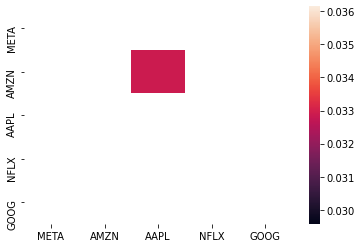

In [10]:
seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    mask = (pvalues >= 0.05)
);

Parece que **AMZN** e **AAPL** são co-integrados!

### **Passo 3: Modele o spread**

Agora que você encontrou um par, execute uma regressão linear usando statsmodels e modele o spread como uma combinação linear de **AAPL** e **AMZN**. *b* é o coeficiente beta da regressão linear, também conhecido como "taxa de cobertura".

In [11]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

NameError: name 'S1' is not defined

In [12]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

NameError: name 'spread' is not defined

### **Passo 4: Crie uma estratégia de negociação simples**

Você compra o spread quando fica "muito baixo" e vende o spread quando fica "muito alto". Mas o que é muito baixo e muito alto? Use o z-score para normalizar o spread e use-o como sinal de negociação. Se você comprar o par, você compra AAPL e vende b ações da AMZN. Se você vender o par, você vende AAPL e compra b ações da AMZN.

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

NameError: name 'spread' is not defined

Primeiro, construa uma função que plote o z-score. Se você não está familiarizado com o z-score, pode aprender mais sobre ele aqui.

Em seguida, estime a curva patrimonial de compra e venda do par.

In [ ]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

Primeiro, crie um DataFrame com o sinal e a posição no par. Em seguida, adicione uma coluna ao DataFrame e preencha-a com 1 quando o sinal for menor ou igual a -1 e -1 quando o sinal for maior ou igual a 1.

Por fim, trace a curva de patrimônio líquido.

In [ ]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()

Este par está constantemente perdendo dinheiro. Isso pode significar algumas coisas. Primeiro, não existe combinação linear estacionária e temos um falso positivo. Ou não há nenhuma relação econômica real que impulsione as duas ações. Ou, há uma combinação linear e há uma relação econômica, mas a relação continuou a se romper durante o quadro que você usou.

***Aviso:***
Este é apenas um exemplo, logo existem algumas ressalvas importantes a serem observadas:

- A negociação de pares assume que os preços das ações são integrados. Tecnicamente, isso significa que uma combinação linear de preços varia em torno de uma média estável na mesma distribuição. Na prática, os traders usam testes de Dickey Fuller aumentados, expoentes de Hurst e filtros de Kalman para testar a cointegração.
- Percorrer pares para encontrar valores-p aumenta a probabilidade de encontrar incorretamente um valor-p significativo quando muitos testes são executados (um falso positivo). Comece com a lógica econômica de por que duas ações devem ser cointegradas. Na prática, os traders escolhem um punhado de ações com vínculos econômicos e as testam.
​